In [112]:
# (Cell 1) Imports & Helper Function

import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title="Image", cmap=None, size=(6,6)):
    """
    Helper function for displaying images in a Jupyter Notebook.
    """
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

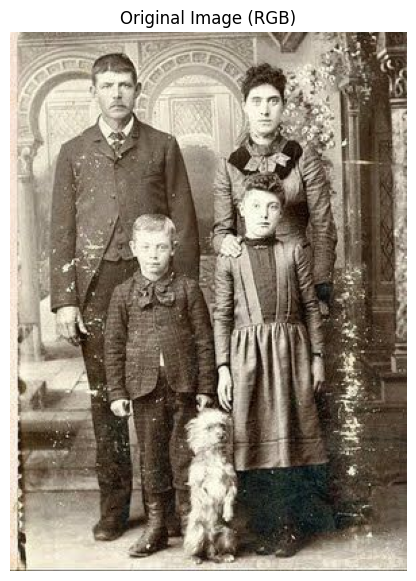

In [113]:
# (Cell 2) Load the Image

# CHANGE THIS to your own filename/path
image_path = r"C:\Users\acer\Downloads\old_photo_restoration\photos\kaggle archive\old_photo_05.jpg"

# OpenCV loads images in BGR
img_bgr = cv2.imread(image_path)

if img_bgr is None:
    print("Error: Could not read the image. Check the path/filename.")
else:
    # Convert BGR -> RGB for plotting
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # Also convert to grayscale for processing
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    show_image(img_rgb, title="Original Image (RGB)", size=(7,7))

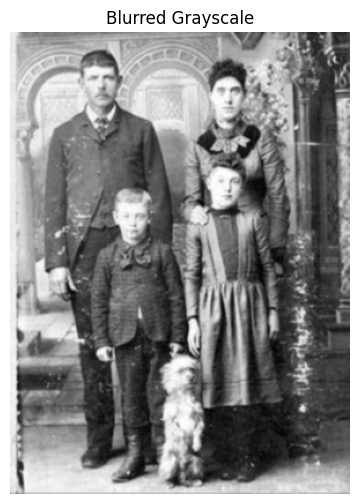

In [114]:
# (Cell 3) Preprocessing: Noise Reduction

if img_bgr is not None:
    # Gaussian blur helps remove minor noise that can produce false edges
    blur_ksize = 3  # You can try 3, 5, or 7
    img_gray_blur = cv2.GaussianBlur(img_gray, (blur_ksize, blur_ksize), 0)

    show_image(img_gray_blur, title="Blurred Grayscale", cmap="gray")

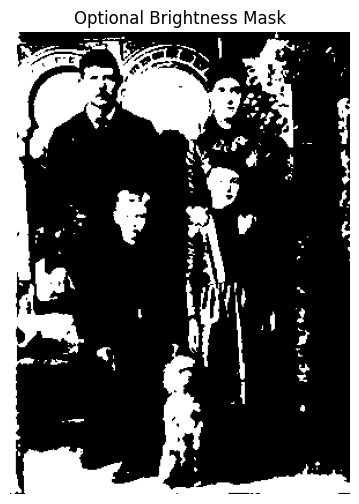

In [115]:
# (Cell 4) Optional Brightness Mask (If Scratches are Often Bright)

if img_bgr is not None:
    # This mask will isolate brighter regions (e.g., if scratches are lighter than background)
    # Adjust brightness_threshold to exclude normal mid-dark areas
    brightness_threshold = 180
    bright_mask = (img_gray_blur > brightness_threshold).astype(np.uint8)

    show_image(bright_mask, "Optional Brightness Mask", cmap="gray")

    # We'll apply edge detection in next cell, then combine it with bright_mask if needed

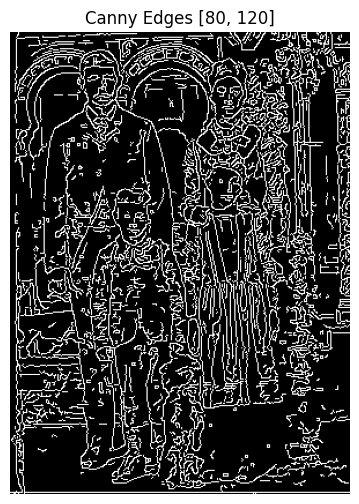

In [116]:
# (Cell 5) Edge Detection (Canny)

if img_bgr is not None:
    # Tweak these thresholds to reduce or amplify edges:
    lower_canny = 80
    upper_canny = 120

    edges = cv2.Canny(img_gray_blur, lower_canny, upper_canny)

    show_image(edges, f"Canny Edges [{lower_canny}, {upper_canny}]", cmap="gray")

    # If you want to combine with brightness mask (only keep edges in bright areas):
    # edges_in_bright = edges & bright_mask
    # show_image(edges_in_bright, "Edges Restricted to Bright Regions", cmap="gray")

    # Decide if you want to proceed with edges or edges_in_bright
    final_edges = edges  # or edges_in_bright

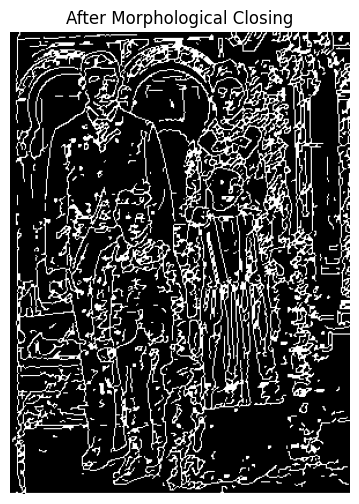

In [117]:
# (Cell 6) Morphological Closing

if img_bgr is not None:
    # Closing = (Dilation -> Erosion)
    kernel_size = 2  # Try 2 or 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    closed_edges = cv2.morphologyEx(final_edges, cv2.MORPH_CLOSE, kernel)

    show_image(closed_edges, "After Morphological Closing", cmap="gray")

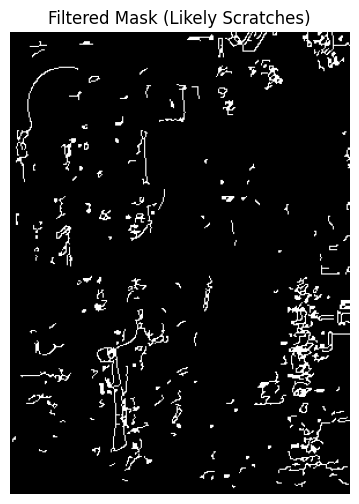

In [118]:
# (Cell 7) Connected Component Analysis to Filter Out Non-Scratches

if img_bgr is not None:
    # Convert to a clean binary mask
    bin_mask = (closed_edges > 0).astype(np.uint8)

    # Get connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)

    # Prepare new mask to keep only "scratch-like" components
    filtered_mask = np.zeros_like(bin_mask)

    # Tweak these:
    min_area = 5        # ignore tiny spots
    max_area = 1500     # ignore big shapes (like face outlines)
    max_aspect_ratio = 4.0  # if bounding box is extremely long/wide, might be noise

    for label_idx in range(1, num_labels):
        x, y, w, h, area = stats[label_idx]

        if area < min_area or area > max_area:
            continue

        # Aspect ratio check (if bounding box is super wide or tall, likely not a scratch)
        aspect_ratio = max(w, h) / (min(w, h) + 1e-5)
        if aspect_ratio > max_aspect_ratio:
            continue

        # If all conditions pass, we keep it
        filtered_mask[labels == label_idx] = 1

    show_image(filtered_mask, "Filtered Mask (Likely Scratches)", cmap="gray")

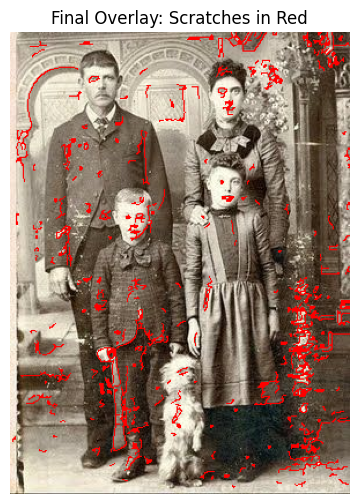

In [119]:
# (Cell 8) Overlay the Final Mask on the Original Image

if img_bgr is not None:
    # Make a copy of the original in RGB
    overlay_result = img_rgb.copy()

    # Color the scratch mask in red
    overlay_result[filtered_mask == 1] = [255, 0, 0]  # (R, G, B)

    show_image(overlay_result, title="Final Overlay: Scratches in Red", size=(6,6))